In [1]:
import os
import numpy as np
from sklearn import tree
from sklearn.linear_model import LinearRegression
import csv
import tensorflow.keras as kr
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Plots style & size
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 10)

# Import csv file and load into data variable
filename="powerproduction.csv"

data = np.loadtxt(filename, delimiter=",", skiprows=1)

# Split numpy array into two arrays, a two dimensional array for x-values, and one dimensional for y-values.
x = data[:,[0]].reshape(-1)
y = (data[:,[1]]).reshape(-1)

In [3]:
# Create pandas dataframe with x and y values formatted 1-dimensionally
train = pd.DataFrame()
train['x'] = x
train['y'] = y

print(train)

          x    y
0     0.000  0.0
1     0.125  0.0
2     0.150  0.0
3     0.225  0.0
4     0.275  0.0
..      ...  ...
495  24.775  0.0
496  24.850  0.0
497  24.875  0.0
498  24.950  0.0
499  25.000  0.0

[500 rows x 2 columns]


Text(0, 0.5, 'Power')

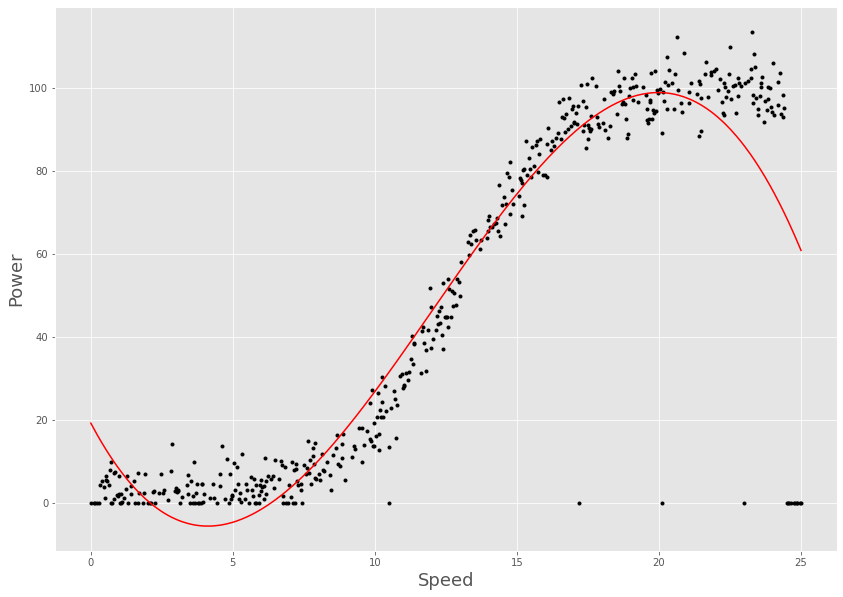

In [4]:
# Plot data for visualization
# The graph looks like a cubic function, f(x) = ax^3 + bx^2 + cx + d
a,b,c,d = np.polyfit(x, y, 3)
plt.plot(x, y, 'k.')
plt.plot(x, a * x * x * x + b * x * x + c * x + d, 'r-')
plt.xlabel("Speed", fontsize=18)
plt.ylabel("Power", fontsize=18)

## Enterpreting data according to the graph
When points are arranged in this type of pattern, and not randomly dispersed about the line, linear regression is not the best predictor for getting results.

According to an environmental research letter which discusses the topic of predicting turbine power output with wind speed, I quote, *The power output from the turbine is not a linear function of wind speed (figure 3), so, multivariate linear regression is not an appropriate technique. Non-linear regression assumes that the relationships are constant throughout the model space (i.e. power output is always proportional to Un), which from figure 3 is incorrect, so non-linear regression is also inappropriate. Also, multivariate bins only work where the training data includes data in all bins and so would be computationally or observationally more expensive. Instead, a technique is required that can capture non-linear changes in response to forcing. For this reason, we propose a machine learning technique called 'regression trees'*[1].

In [5]:
# Using keras neural network to try to predict values.
model = kr.models.Sequential()
model.add(kr.layers.Dense(1, input_shape=(1,), activation="linear", kernel_initializer='ones', bias_initializer='zeros'))
model.compile('adam', loss='mean_squared_error')

In [6]:
# Train network with our data
model.fit(train['x'], train['y'], epochs=500)

Epoch 1/500
16/16 [==============================] - 0s 467us/step - loss: 2485.6611
Epoch 2/500
16/16 [==============================] - 0s 533us/step - loss: 2415.4016
Epoch 3/500
16/16 [==============================] - 0s 533us/step - loss: 2246.1137
Epoch 4/500
16/16 [==============================] - 0s 533us/step - loss: 2604.3906
Epoch 5/500
16/16 [==============================] - 0s 466us/step - loss: 2555.2519
Epoch 6/500
16/16 [==============================] - 0s 467us/step - loss: 2450.2967
Epoch 7/500
16/16 [==============================] - 0s 467us/step - loss: 2360.3492
Epoch 8/500
16/16 [==============================] - 0s 467us/step - loss: 2545.3059
Epoch 9/500
16/16 [==============================] - 0s 467us/step - loss: 2140.7634
Epoch 10/500
16/16 [==============================] - 0s 533us/step - loss: 2474.6472
Epoch 11/500
16/16 [==============================] - 0s 467us/step - loss: 2389.9964
Epoch 12/500
16/16 [==============================] - 0s 467us/

16/16 [==============================] - 0s 400us/step - loss: 1082.4029
Epoch 97/500
16/16 [==============================] - 0s 467us/step - loss: 1184.9825
Epoch 98/500
16/16 [==============================] - 0s 467us/step - loss: 1115.1314
Epoch 99/500
16/16 [==============================] - 0s 400us/step - loss: 1133.6645
Epoch 100/500
16/16 [==============================] - 0s 467us/step - loss: 1153.2232
Epoch 101/500
16/16 [==============================] - 0s 467us/step - loss: 1136.6080
Epoch 102/500
16/16 [==============================] - 0s 467us/step - loss: 1169.2251
Epoch 103/500
16/16 [==============================] - 0s 467us/step - loss: 1017.2283
Epoch 104/500
16/16 [==============================] - 0s 400us/step - loss: 1110.9062
Epoch 105/500
16/16 [==============================] - 0s 467us/step - loss: 1121.7769
Epoch 106/500
16/16 [==============================] - 0s 467us/step - loss: 1018.4973
Epoch 107/500
16/16 [==============================] - 0s 46

Epoch 191/500
16/16 [==============================] - 0s 466us/step - loss: 636.3632
Epoch 192/500
16/16 [==============================] - 0s 467us/step - loss: 646.5979
Epoch 193/500
16/16 [==============================] - 0s 400us/step - loss: 703.5209
Epoch 194/500
16/16 [==============================] - 0s 400us/step - loss: 612.7882
Epoch 195/500
16/16 [==============================] - 0s 400us/step - loss: 603.3712
Epoch 196/500
16/16 [==============================] - 0s 467us/step - loss: 604.9587
Epoch 197/500
16/16 [==============================] - 0s 467us/step - loss: 612.2540
Epoch 198/500
16/16 [==============================] - 0s 467us/step - loss: 710.1563
Epoch 199/500
16/16 [==============================] - 0s 467us/step - loss: 695.0705
Epoch 200/500
16/16 [==============================] - 0s 467us/step - loss: 584.4006
Epoch 201/500
16/16 [==============================] - 0s 400us/step - loss: 628.4885
Epoch 202/500
16/16 [==============================] -

16/16 [==============================] - 0s 467us/step - loss: 517.8135
Epoch 287/500
16/16 [==============================] - 0s 467us/step - loss: 545.6267
Epoch 288/500
16/16 [==============================] - 0s 467us/step - loss: 540.2260
Epoch 289/500
16/16 [==============================] - 0s 400us/step - loss: 489.0181
Epoch 290/500
16/16 [==============================] - 0s 467us/step - loss: 486.1400
Epoch 291/500
16/16 [==============================] - 0s 467us/step - loss: 503.8893
Epoch 292/500
16/16 [==============================] - 0s 467us/step - loss: 519.0451
Epoch 293/500
16/16 [==============================] - 0s 467us/step - loss: 481.6254
Epoch 294/500
16/16 [==============================] - 0s 467us/step - loss: 610.6892
Epoch 295/500
16/16 [==============================] - 0s 467us/step - loss: 524.4998
Epoch 296/500
16/16 [==============================] - 0s 467us/step - loss: 600.6067
Epoch 297/500
16/16 [==============================] - 0s 466us/step

16/16 [==============================] - 0s 467us/step - loss: 572.5516
Epoch 382/500
16/16 [==============================] - 0s 467us/step - loss: 435.8633
Epoch 383/500
16/16 [==============================] - 0s 466us/step - loss: 493.9256
Epoch 384/500
16/16 [==============================] - 0s 467us/step - loss: 526.9218
Epoch 385/500
16/16 [==============================] - 0s 467us/step - loss: 485.0710
Epoch 386/500
16/16 [==============================] - 0s 467us/step - loss: 426.6719
Epoch 387/500
16/16 [==============================] - 0s 467us/step - loss: 495.8157
Epoch 388/500
16/16 [==============================] - 0s 400us/step - loss: 529.1263
Epoch 389/500
16/16 [==============================] - 0s 466us/step - loss: 460.0988
Epoch 390/500
16/16 [==============================] - 0s 467us/step - loss: 391.2624
Epoch 391/500
16/16 [==============================] - 0s 400us/step - loss: 558.6023
Epoch 392/500
16/16 [==============================] - 0s 400us/step

16/16 [==============================] - 0s 467us/step - loss: 451.0030
Epoch 477/500
16/16 [==============================] - 0s 467us/step - loss: 483.4188
Epoch 478/500
16/16 [==============================] - 0s 400us/step - loss: 493.5460
Epoch 479/500
16/16 [==============================] - 0s 467us/step - loss: 520.9566
Epoch 480/500
16/16 [==============================] - 0s 467us/step - loss: 542.6005
Epoch 481/500
16/16 [==============================] - 0s 467us/step - loss: 557.3764
Epoch 482/500
16/16 [==============================] - 0s 467us/step - loss: 541.6762
Epoch 483/500
16/16 [==============================] - 0s 467us/step - loss: 546.5130
Epoch 484/500
16/16 [==============================] - 0s 533us/step - loss: 393.9244
Epoch 485/500
16/16 [==============================] - 0s 467us/step - loss: 523.4545
Epoch 486/500
16/16 [==============================] - 0s 467us/step - loss: 460.4592
Epoch 487/500
16/16 [==============================] - 0s 467us/step

In [7]:
# Predict values with model created with Keras
model.predict([1.5, 5.5, 10.5, 25, 30])

array([[  6.3649073],
       [ 22.571754 ],
       [ 42.83031  ],
       [101.580124 ],
       [121.838684 ]], dtype=float32)

***The results obtained from linear regression predictions are obviously highly innacurate when trying to predict values that aren't a linear function, so I tried to find a decision tree model in the Keras documentation or StackOverflow. I decided to go with sci-kit learn's decision tree as it was still providing accurate results and is recommended by the Environmental reserarch letter[1].***

In [8]:
x = data[:,[0]]
decision_tree_model = tree.DecisionTreeRegressor().fit(x, y)

In [9]:
pred = decision_tree_model.predict([[15]])
print(pred)

[73.911]


According to the powerproduction dataset, a speed of 15.065 generates a power value of 73.911. So the model is pretty accurate.

## References

[1] Clifton, A., Kilcher, L., Lundquist, J.K. and Fleming, P., 2013. Using machine learning to predict wind turbine power output. Environmental research letters, 8(2), p.024009.